# Part1 (Optimization)

### Library

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

### Import the Diabetes data (Training+Validation+Test)

In [25]:
############################################################################################ import the dataset
training_dataset = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_train.csv')
val_dataset = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_val.csv')
test_dataset = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_test.csv')

x_t, y_t = training_dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']][::], training_dataset['Outcome']
x_v, y_v = val_dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']][::], val_dataset['Outcome']
x_test, y_test = test_dataset[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']][::], test_dataset['Outcome']

scaler = preprocessing.StandardScaler()
x_t = scaler.fit_transform(x_t)
x_v = scaler.fit_transform(x_v)
x_test = scaler.fit_transform(x_v)

############################################################################################ import the dataset
tdf = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_train.csv')
vdf = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_val.csv')
test_df = pd.read_csv(r'C:\Users\lenovo\Desktop\data_A2\data_A2\diabetes\diabetes_test.csv')

b_y_t, b_y_v, b_y_test = tdf.iloc[: , -1:], vdf.iloc[: , -1:], test_df.iloc[: , -1:]
x_t_raw, x_v_raw, x_test_raw = tdf.iloc[: , :-1], vdf.iloc[: , :-1], test_df.iloc[: , :-1]
scaler = preprocessing.StandardScaler()

b_x_t = scaler.fit_transform(x_t_raw)
b_x_v = scaler.fit_transform(x_v_raw)
b_x_test = scaler.fit_transform(x_test_raw)

### Implement help functions

In [26]:
############################################################################################ logistic function:
def logistic(x):
    return 1/(1+np.exp(-x))
############################################################################################ accuracy function:
def accuracy(y, yh):
    yh = np.rint(yh)
    return (yh == y).sum() / len(y)
############################################################################################ cost function:
def cost(x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)))
    return J

### Implement LogisticRegression Class

In [27]:
############################################################################################ Logistic regression class
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=3e-4, epsilon=1e-4, max_iters=5e5, verbose=False, momentum=0.9, with_momentum=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.momentum = momentum
        self.with_momentum = with_momentum

    def fit(self, x_train, y_train, x_val, y_val):

        if self.add_bias:
            M = x_train.shape[0]
            x_train = np.column_stack([x_train, np.ones(M)])
            N = x_val.shape[0]
            x_val = np.column_stack([x_val, np.ones(N)])

        D = x_train.shape[1]
        self.w = np.zeros(D)
        g = np.inf
        delta_w_previous = np.zeros(self.w.shape)
        t = 0

        # the code snippet below is for gradient descent
        list_of_val_accuracies = []
        list_of_train_lost = []
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:

            if self.with_momentum:
                grad = self.gradient(x_train, y_train)
                delta_w = self.momentum * delta_w_previous + (1 - self.momentum) * grad
                delta_w_previous = delta_w
                self.w = self.w - self.learning_rate * delta_w
            else:
                grad = self.gradient(x_train, y_train)
                self.w = self.w - self.learning_rate * grad
            
            yh_val = self.predict(x_val)
            cost_train = self.cost_fn(x_train, y_train)
            accuracy_val = accuracy(y_val, yh_val)
            list_of_train_lost.append(cost_train)
            list_of_val_accuracies.append(accuracy_val)

            t += 1

        is_fully_converge = False
        if t < self.max_iters:
            is_fully_converge = True

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, t, list_of_train_lost, list_of_val_accuracies, is_fully_converge

    def predict(self, x):
        return logistic(np.dot(x, self.w))

    def cost_fn(self, x, y):
        z = np.dot(x, self.w)
        J = np.mean(y * np.log1p(np.exp(-z)) + (1 - y) * np.log1p(np.exp(z)))  # log1p calculates log(1+x) to remove floating point inaccuracies
        return J

    def gradient(self, x, y):
        N, D = x.shape
        yh = logistic(np.dot(x, self.w))  # predictions  size N
        grad = np.dot(x.T, yh - y) / N  # divide by N because cost is mean over N points
        return grad

### Implement mini-batch Class

In [28]:
class mini_batch:
    def __init__(self,learning_rate=3e-4, max_iters=5e5, epsilon=1e-4, with_momentum=False,momentum=0.9):
        self.lr = learning_rate
        self.iters=max_iters
        self.epsilon = epsilon  
        self.momentum=momentum
        self.with_momentum=with_momentum
        self.batches=list()
 
    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions 
        grad = np.dot(x.T, yh - y)/N        # avg gradient of one batch
        return grad                         
    
    def create_batches(self, X, y, batch_size):
        batches = []
        data = np.hstack((X, y))
        np.random.shuffle(data)   # seed or not???
        self.num_batches = data.shape[0] // batch_size

        for i in range(self.num_batches): 
            batch = data[i * batch_size:(i + 1)*batch_size]
            batches.append((batch[:,:-1],batch[:,-1:]))

        if data.shape[0] % batch_size != 0:
            batch = data[i * batch_size:]
            batches.append((batch[:,:-1],batch[:,-1:]))
            self.num_batches+=1
        return (batches)
    
    def gradient_descent(self, X, y, X_test, y_test, batch_size):
        
        train_err= list()
        val_acc = list()

        # add bias to both train and validation
        N_X = X.shape[0]
        X = np.column_stack([X,np.ones(N_X)])
        N_X_test = X_test.shape[0]
        X_test = np.column_stack([X_test, np.ones(N_X_test)])

        self.w = np.zeros((X.shape[1],1))
        g = np.inf 
        delta_w = np.zeros(self.w.shape)
        iter = 0
        while np.linalg.norm(g) > self.epsilon and iter < self.iters:
            self.batches=self.create_batches(X,y,batch_size)
            
            for j in range(self.num_batches):
                
                X_batch =self.batches[j][0]
                y_batch =self.batches[j][1]
                
                if self.with_momentum: 
                    delta_w_new = self.momentum*delta_w+(1-self.momentum)*self.gradient(X_batch,y_batch)
                    delta_w = delta_w_new
                    self.w = (self.w - self.lr * delta_w_new)  #shape (8,1)
                else: 
                    g=self.gradient(X_batch,y_batch)
                    self.w = (self.w - self.lr * g)  #shape (8,1)
                
            yh_test = logistic(np.dot(X_test, self.w))
            train_err.append(cost(X, y, self.w))
            val_acc.append(accuracy(y_test, yh_test))

            iter+=1
            
        if self.with_momentum:
            print(f'terminated after: {iter} iterations with momentum = {self.momentum}')
        else:
            print(f'terminated after: {iter} iterations')
        return train_err,val_acc

### 1.1 find the optimal learning rate and max iteration

learning_rate & number_of_iteration combination comparison
***************************************************************************
For learning rate = 0.0003, max iterations = 10000.0: program ceased after iterations of 10000. The final accuracy = 0.72 and does not fully converges within epsilon = 0.0001


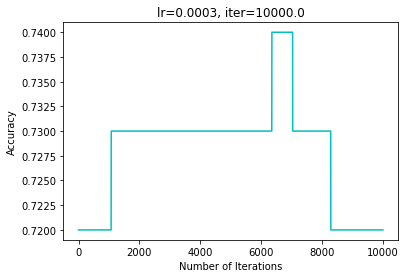

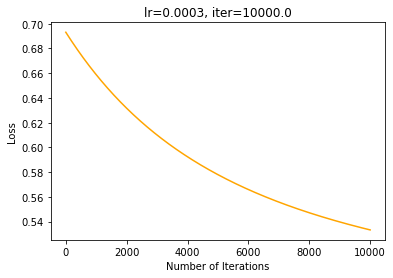

***************************************************************************
For learning rate = 0.0003, max iterations = 100000.0: program ceased after iterations of 100000. The final accuracy = 0.76 and does not fully converges within epsilon = 0.0001


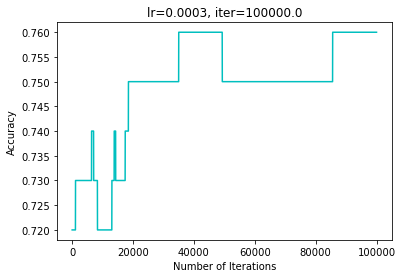

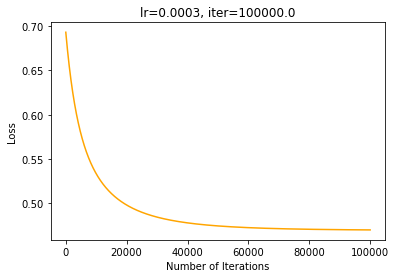

***************************************************************************
For learning rate = 0.0003, max iterations = 500000.0: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


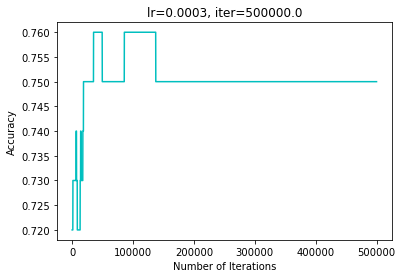

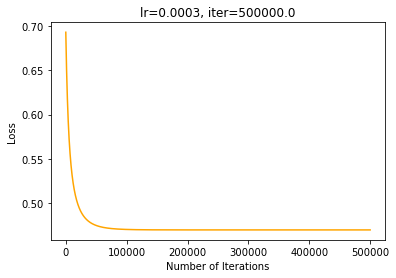

***************************************************************************
For learning rate = 1e-05, max iterations = 10000.0: program ceased after iterations of 10000. The final accuracy = 0.72 and does not fully converges within epsilon = 0.0001


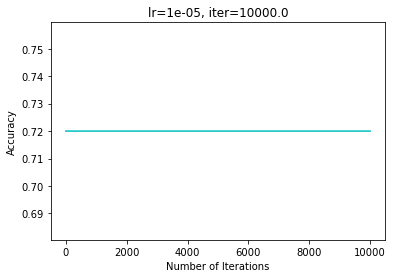

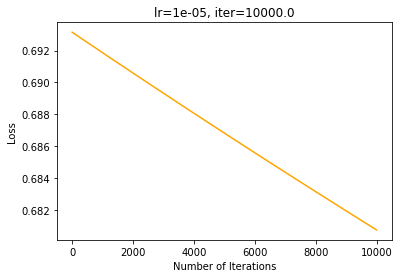

***************************************************************************
For learning rate = 1e-05, max iterations = 100000.0: program ceased after iterations of 100000. The final accuracy = 0.73 and does not fully converges within epsilon = 0.0001


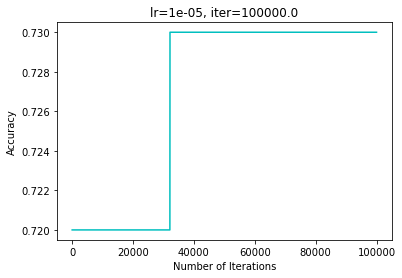

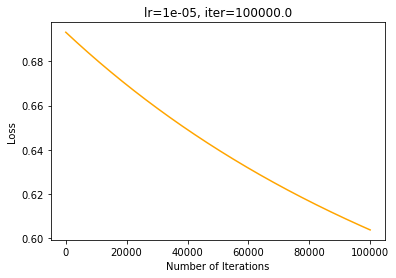

***************************************************************************
For learning rate = 1e-05, max iterations = 500000.0: program ceased after iterations of 500000. The final accuracy = 0.73 and does not fully converges within epsilon = 0.0001


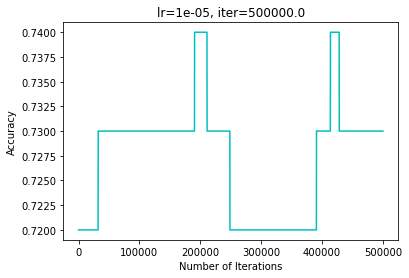

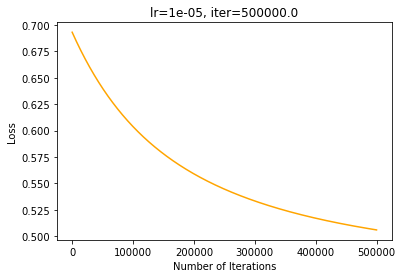

***************************************************************************
Final result:


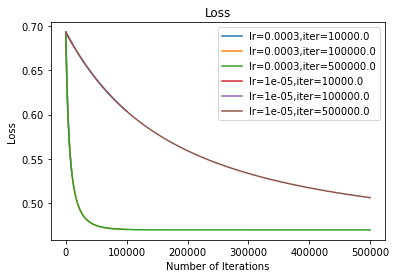

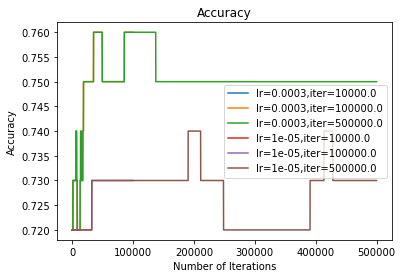

In [29]:
####################################################### Q1 function: find the optimal learning rate and max_iter
array_of_learning_rate = [3e-4, 1e-5]
array_of_max_iters = [1e4, 1e5, 5e5]
def compare_parameters(array_of_learning_rate, array_of_max_iters):
    print("learning_rate & number_of_iteration combination comparison")
    list_of_timing = []
    big_list_accuracies = []
    big_list_loss = []
    train_err_hist = []
    val_acc_hist = []
    fastest = np.inf
    fastest_permutation = "There's no combination which converges!"
    most_accurate = 0
    most_accurate_permutation = "There's no combination which converges!"
    my_line = '***************************************************************************'

    for rate in array_of_learning_rate:
        for iteration in array_of_max_iters:
            model = LogisticRegression(add_bias=True, epsilon=1e-4, learning_rate=rate, max_iters=iteration, with_momentum=False)  # declare the model
            model, t, list_of_train_loss, list_of_val_accuracies, is_fully_converge = model.fit(x_t, y_t, x_v, y_v)

            big_list_accuracies.append(list_of_val_accuracies[-1])
            big_list_loss.append(list_of_train_loss[-1])
            val_acc_hist.append(list_of_val_accuracies)
            train_err_hist.append(list_of_train_loss)
            list_of_timing.append(t)

            print(my_line)
            if is_fully_converge:
                print(f'For learning rate = {rate}, max iterations = {iteration}: program ceased after iterations of {t}. The final accuracy = {list_of_val_accuracies[-1]} and fully converges within epsilon = {model.epsilon}')
            else:
                print(f'For learning rate = {rate}, max iterations = {iteration}: program ceased after iterations of {t}. The final accuracy = {list_of_val_accuracies[-1]} and does not fully converges within epsilon = {model.epsilon}')
            if t < fastest:
                fastest = t
                fastest_permutation = f'Fastest permutation is learning rate = {rate}, max iterations = {iteration}: the program stops after {t} numbers of iteration'
            if list_of_val_accuracies[-1] >= most_accurate:
                most_accurate = list_of_val_accuracies[-1]
                most_accurate_permutation = f'Most accurate permutation is learning rate = {rate}, max iterations = {iteration}: the final accuracy equals {most_accurate}'

            # Draw the acc&loss graph for each permutation
            plt.plot(list_of_val_accuracies, color='c')
            plt.title(f'lr={rate}, iter={iteration}')
            plt.xlabel('Number of Iterations')
            plt.ylabel('Accuracy')
            plt.show()
            plt.plot(list_of_train_loss, color='orange')
            plt.title(f'lr={rate}, iter={iteration}')
            plt.xlabel('Number of Iterations')
            plt.ylabel('Loss')
            plt.show()
    print(my_line)

    print('Final result:')
    # draw all the loss together!
    i=0
    for rate in array_of_learning_rate:
        for iteration in array_of_max_iters:
            plt.plot(train_err_hist[i], label=f'lr={rate},iter={iteration}')
            i+=1
    plt.title('Loss') 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # draw all the accuracy together!
    j=0
    for rate in array_of_learning_rate:
        for iteration in array_of_max_iters:
            plt.plot(val_acc_hist[j], label=f'lr={rate},iter={iteration}')
            j+=1
    plt.title('Accuracy') 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # find the optimal running time and the most_accurate
    # print(fastest_permutation)
    # print(most_accurate_permutation)

compare_parameters(array_of_learning_rate, array_of_max_iters)

### 1.2 Implement mini-batch and find the best configuration

batch size comparison
***************************************************************************
Visualizations for batch size = 256:
terminated after: 500000 iterations


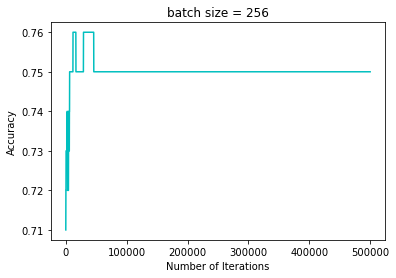

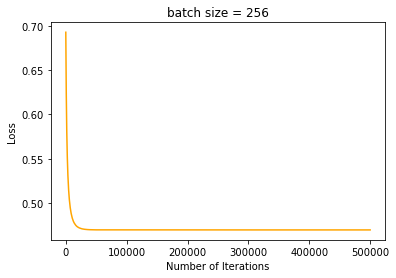

***************************************************************************
Visualizations for batch size = 128:
terminated after: 500000 iterations


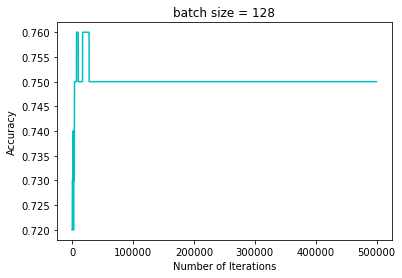

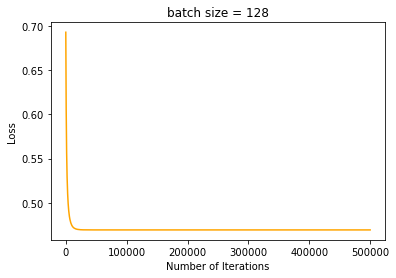

***************************************************************************
Visualizations for batch size = 64:
terminated after: 500000 iterations


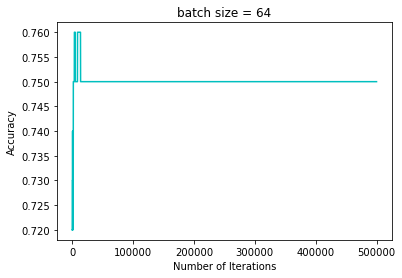

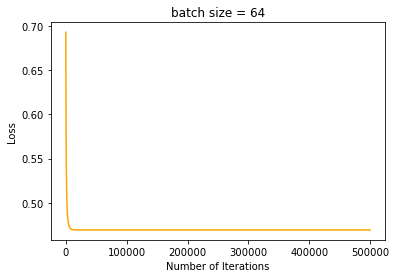

***************************************************************************
Visualizations for batch size = 32:
terminated after: 500000 iterations


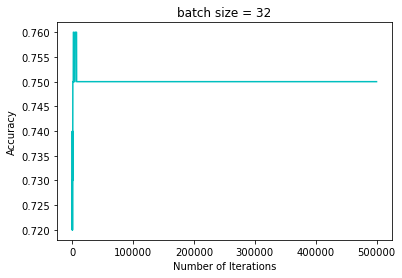

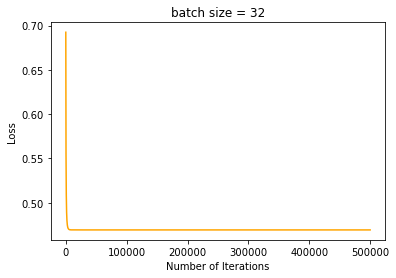

***************************************************************************
Visualizations for batch size = 8:
terminated after: 500000 iterations


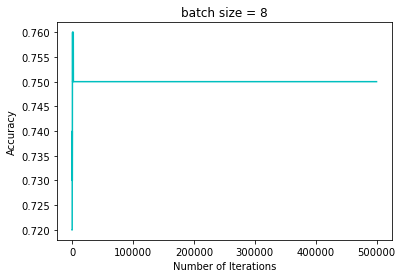

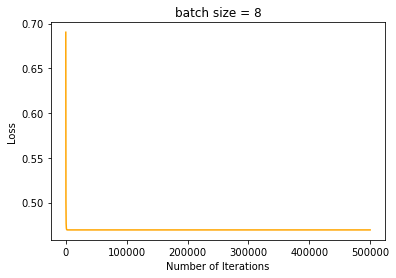

***************************************************************************
Final result:


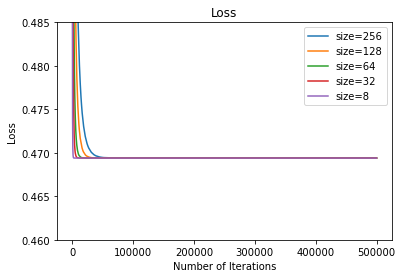

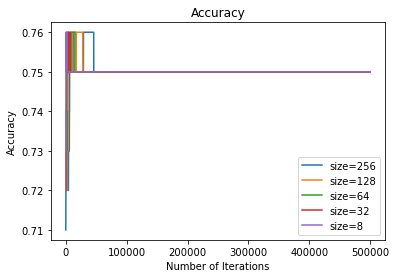

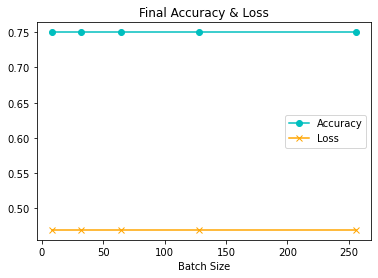

In [7]:
sizes=[256,128,64,32,8]
def compare(size_list):
    print('batch size comparison')
    acc_final=list()
    cost_final=list()
    val_acc_hist = []
    train_err_hist = []
    my_line = '***************************************************************************'
    
    for s in size_list:
        print(my_line)
        print(f"Visualizations for batch size = {s}:")
        size = mini_batch()
        train_err,val_acc = size.gradient_descent(b_x_t, b_y_t, b_x_v, b_y_v, s)
        
        acc_final.append(val_acc[-1]) #final validation acc
        cost_final.append(train_err[-1])
        
        val_acc_hist.append(val_acc)
        train_err_hist.append(train_err)
        
        # Draw the acc&loss graph for each permutation
        plt.plot(val_acc, color='c')
        plt.title(f'batch size = {s}')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Accuracy')
        plt.show()
        plt.plot(train_err, color='orange')
        plt.title(f'batch size = {s}')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Loss')
        plt.show()
    print(my_line)

    print('Final result:')
    # draw all the loss together!
    i=0
    for s in size_list:
        plt.plot(train_err_hist[i], label=f'size={s}')
        i+=1
    plt.title('Loss') 
    plt.ylim(0.46,0.485) 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # draw all the accuracy together!
    j=0
    for s in size_list:
        plt.plot(val_acc_hist[j], label=f'size={s}')
        j+=1
    plt.title('Accuracy') 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # plot the converged acc&loss graph
    plt.plot(size_list, acc_final, color='c', label="Accuracy", marker='o')
    plt.plot(size_list, cost_final, color='orange', label="Loss", marker='x')
    plt.title('Final Accuracy & Loss')
    plt.xlabel('Batch Size')
    plt.legend()
    plt.show()
    
    return None

compare(sizes)

### 1.3 find the optimal momentum

momentum horizontal comparison
***************************************************************************
For momentum = 0.5: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


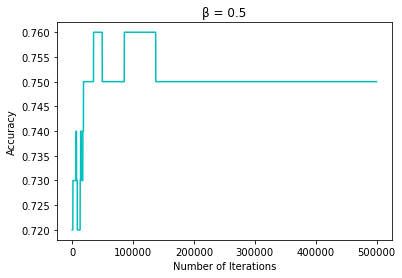

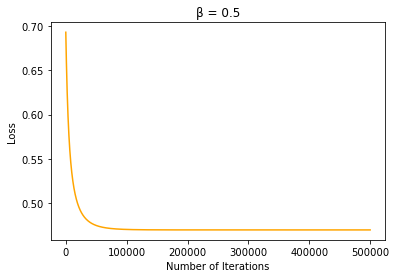

***************************************************************************
For momentum = 0.7: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


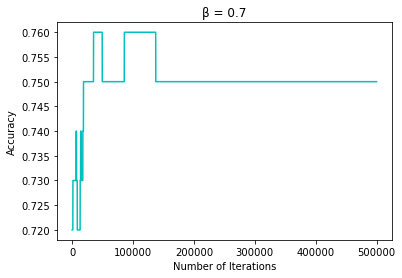

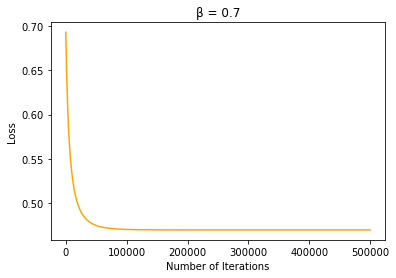

***************************************************************************
For momentum = 0.9: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


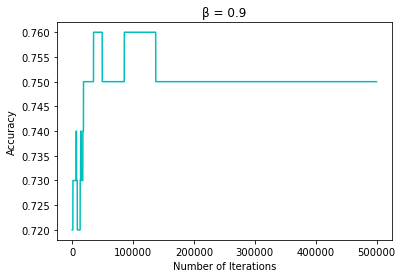

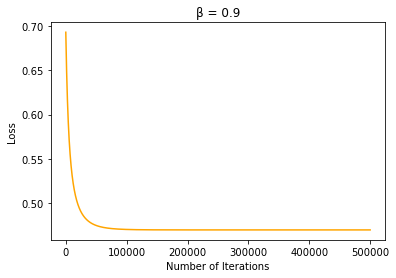

***************************************************************************
For momentum = 0.99: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


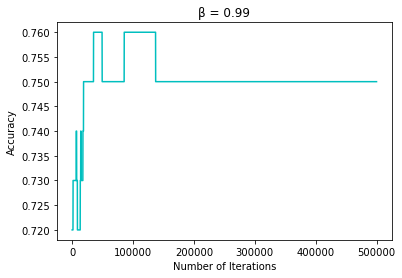

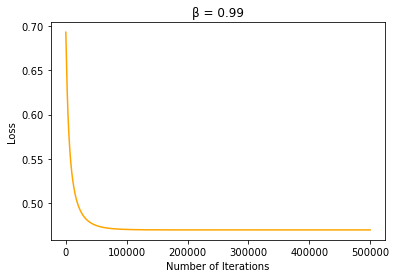

***************************************************************************
For momentum = 0.999: program ceased after iterations of 500000. The final accuracy = 0.75 and does not fully converges within epsilon = 0.0001


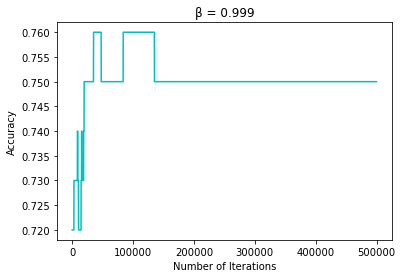

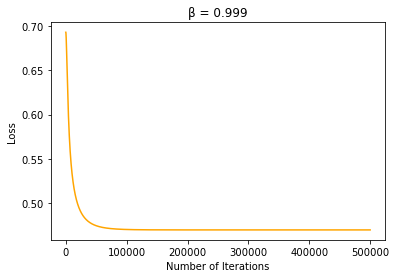

***************************************************************************
Final result:


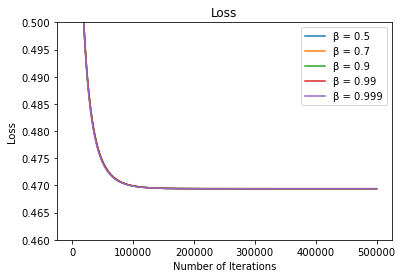

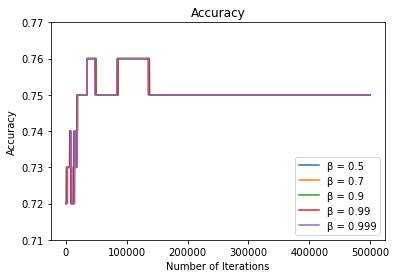

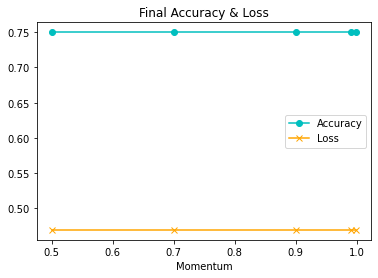

In [31]:
########################################################## Q3 function: find the optimal momentum
array_of_momentum = [0.5, 0.7, 0.9, 0.99, 0.999]
def compare_momentum(array_of_momentum):
    print("momentum horizontal comparison")
    list_of_timing = []
    big_list_accuracies = []
    big_list_loss = []
    val_acc_hist = []
    train_err_hist = []
    fastest = np.inf
    fastest_permutation = "There's no combination which converges!"
    most_accurate = 0
    most_accurate_permutation = "There's no combination which converges!"
    my_line = '***************************************************************************'

    for momentum in array_of_momentum:
        model = LogisticRegression(add_bias=True, epsilon=1e-4, learning_rate=3e-4, max_iters=5e5, momentum=momentum, with_momentum=True)  # declare the model
        model, t, list_of_train_loss, list_of_val_accuracies, is_fully_converge = model.fit(x_t, y_t, x_v, y_v)

        big_list_accuracies.append(list_of_val_accuracies[-1])
        big_list_loss.append(list_of_train_loss[-1])
        val_acc_hist.append(list_of_val_accuracies)
        train_err_hist.append(list_of_train_loss)
        list_of_timing.append(t)

        print(my_line)
        if is_fully_converge:
            print(f'For momentum = {momentum}: program ceased after iterations of {t}. The final accuracy = {list_of_val_accuracies[-1]} and fully converges within epsilon = {model.epsilon}')
        else:
            print(f'For momentum = {momentum}: program ceased after iterations of {t}. The final accuracy = {list_of_val_accuracies[-1]} and does not fully converges within epsilon = {model.epsilon}')
        if t < fastest:
            fastest = t
            fastest_permutation = f'Fastest permutation is momentum = {momentum}: the program stops after {t} numbers of iteration'
        if list_of_val_accuracies[-1] >= most_accurate:
            most_accurate = list_of_val_accuracies[-1]
            most_accurate_permutation = f'Most accurate permutation is momentum = {momentum}: the final accuracy equals {most_accurate}'

        # Draw the acc&loss graph for each momentum
        plt.plot(list_of_val_accuracies, color='c')
        plt.title('\u03B2' + f' = {momentum}')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Accuracy')
        plt.show()
        plt.plot(list_of_train_loss, color='orange')
        plt.title('\u03B2' + f' = {momentum}')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Loss')
        plt.show()
    print(my_line)

    print('Final result:')
    # draw all the loss together!
    i=0
    for momentum in array_of_momentum:
        plt.plot(train_err_hist[i], label='\u03B2' + f' = {momentum}')
        i+=1
    plt.title('Loss') 
    plt.ylim(0.46,0.50) 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # draw all the accuracy together!
    j=0
    for momentum in array_of_momentum:
        plt.plot(val_acc_hist[j], label='\u03B2' + f' = {momentum}')
        j+=1
    plt.title('Accuracy') 
    plt.ylim(0.71,0.77) 
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # plot the converged acc&loss graph
    plt.plot(array_of_momentum, big_list_accuracies, color='c', label="Accuracy", marker='o')
    plt.plot(array_of_momentum, big_list_loss, color='orange', label="Loss", marker='x')
    plt.title('Final Accuracy & Loss')
    plt.xlabel('Momentum') 
    plt.legend()
    plt.show()

    # find the optimal running time and the most_accurate
    # print(fastest_permutation)
    # print(most_accurate_permutation)
    
compare_momentum(array_of_momentum)

### 1.4 Test momentum on different batch sizes (full-batch, small-batch, large-batch)

***************************************************************************
Visualizations for batch size = 600:
terminated after: 500000 iterations with momentum = 0.5
terminated after: 500000 iterations with momentum = 0.7
terminated after: 500000 iterations with momentum = 0.9
terminated after: 500000 iterations with momentum = 0.99
terminated after: 500000 iterations with momentum = 0.999


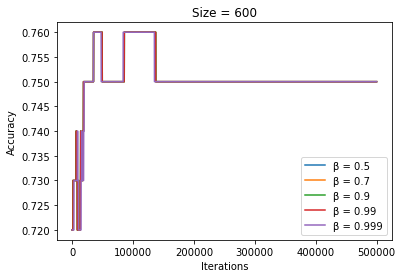

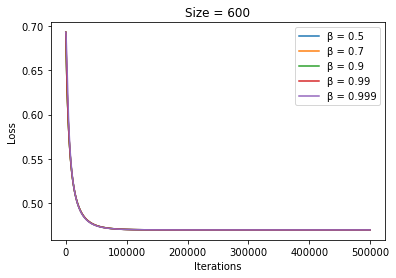

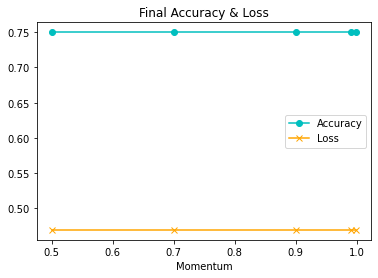

***************************************************************************
Visualizations for batch size = 256:
terminated after: 500000 iterations with momentum = 0.5
terminated after: 500000 iterations with momentum = 0.7
terminated after: 500000 iterations with momentum = 0.9
terminated after: 500000 iterations with momentum = 0.99
terminated after: 500000 iterations with momentum = 0.999


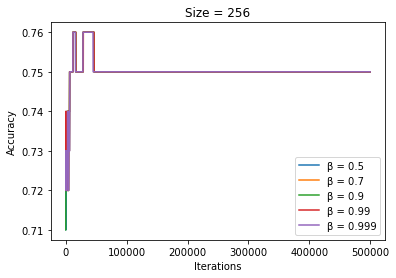

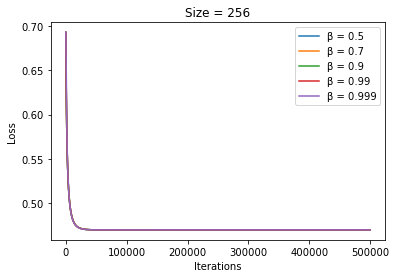

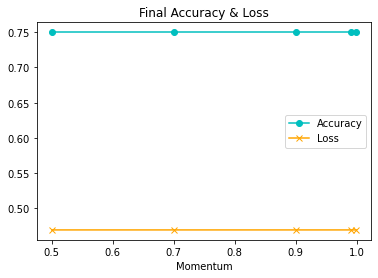

***************************************************************************
Visualizations for batch size = 8:
terminated after: 500000 iterations with momentum = 0.5
terminated after: 500000 iterations with momentum = 0.7
terminated after: 500000 iterations with momentum = 0.9
terminated after: 500000 iterations with momentum = 0.99
terminated after: 500000 iterations with momentum = 0.999


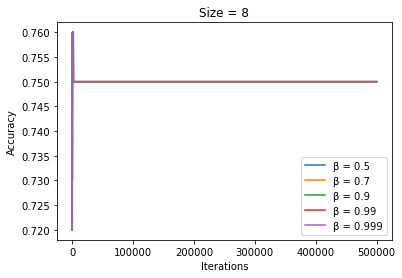

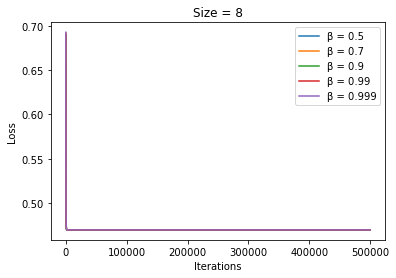

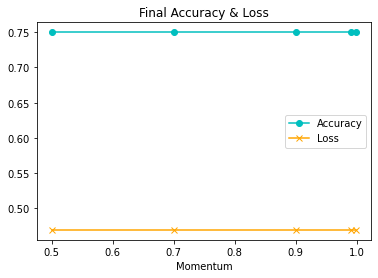

In [9]:
batch_sizes = [600, 256, 8]
array_of_momentum = [0.5, 0.7, 0.9, 0.99, 0.999]
def compare_batch_momentum(size_list, array_of_momentum):
    for s in size_list:
        acc_final=list()
        cost_final=list()
        train_err_hist=list()
        val_acc_hist=list()
        my_line = '***************************************************************************'
        
        print(my_line)
        print(f"Visualizations for batch size = {s}:")
        for m in array_of_momentum:
            
            trial=mini_batch(with_momentum=True,momentum=m)
            train_err,val_acc = trial.gradient_descent(b_x_t, b_y_t, b_x_v, b_y_v, s)
            
            acc_final.append(val_acc[-1])
            cost_final.append(train_err[-1])
            
            val_acc_hist.append(val_acc)
            train_err_hist.append(train_err)
            
        # for the same size, we plot its accuracy and loss graph for each momentum value
        # accuracy graph
        i=0
        while i < len(array_of_momentum):
            m=array_of_momentum[i]
            plt.plot(val_acc_hist[i], label='\u03B2' + f' = {m}')
            i+=1
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.title(f'Size = {s}')
        plt.legend()
        plt.show()
        
        # loss graph
        i=0
        while i < len(array_of_momentum):
            m=array_of_momentum[i]
            plt.plot(train_err_hist[i], label='\u03B2' + f' = {m}')
            i+=1
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title(f'Size = {s}')
        plt.legend()
        plt.show()       
        
        # final loss & accuracy
        plt.plot(array_of_momentum, acc_final, label = "Accuracy", color='c', marker='o') 
        plt.plot(array_of_momentum, cost_final, label = "Loss", color='orange', marker='x') 
        plt.xlabel('Momentum')
        plt.title('Final Accuracy & Loss')
        plt.legend()
        plt.show() 
    return None

compare_batch_momentum(batch_sizes, array_of_momentum)

### Creativity: L2 Regularization

In [38]:
class mini_batch_l2:
    def __init__(self,learning_rate=0.0003, max_iters=500000, epsilon=1e-4, with_momentum=False,momentum=0,lam=0):
        self.lr = learning_rate
        self.iters=max_iters
        self.epsilon = epsilon  
        self.momentum=momentum
        self.with_momentum=with_momentum
        self.batches=list()
        self.lam=lam
 
    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions 
        grad = np.dot(x.T, yh - y)/N        # avg gradient of one batch
        return grad                         
    
    
    def create_batches(self, X, y, batch_size):
        batches = []
        data = np.hstack((X, y))
        np.random.shuffle(data)   # seed or not???
        self.num_batches = data.shape[0] // batch_size

        for i in range(self.num_batches): #num_batches+1 ??
            batch = data[i * batch_size:(i + 1)*batch_size]
            #print(batch)
            batches.append((batch[:,:-1],batch[:,-1:]))

        if data.shape[0] % batch_size != 0:
            batch = data[i * batch_size:]
            batches.append((batch[:,:-1],batch[:,-1:]))
            self.num_batches+=1
        return (batches)
    
    def gradient_descent(self, X, y, X_test, y_test, batch_size):
        
        train_err= list()
        test_err= list()
        train_acc=list()
        val_acc = list()

        N_X = X.shape[0]
        X = np.column_stack([X,np.ones(N_X)])
        N_X_test = X_test.shape[0]
        X_test = np.column_stack([X_test,np.ones(N_X_test)])


        self.w = np.zeros((X.shape[1],1))
        self.g = np.inf 
        iter=0
        delta_w = np.zeros(self.w.shape)
        #for i in range(self.iters):
        while np.linalg.norm(self.g) > self.epsilon and iter < self.iters:
            self.batches=self.create_batches(X,y,batch_size)
            #self.batches=[600]
            #self.num_batches=1
            for j in range(self.num_batches):
                #X_batch=X
                #y_batch=y
                X_batch =self.batches[j][0]
                y_batch =self.batches[j][1]

                if self.with_momentum: 
                    delta_w_new = self.momentum*delta_w+(1-self.momentum)*(self.gradient(X_batch,y_batch)+self.lam*self.w)
                    delta_w = delta_w_new
                    self.w = (self.w - self.lr * delta_w_new)  #shape (8,1)
                else: 
                    self.g=self.gradient(X_batch,y_batch)+self.lam*self.w 
                    self.w = (self.w - self.lr * self.g)  #shape (8,1)               
                
                

            yh=logistic(np.dot(X, self.w))
            yh_test = logistic(np.dot(X_test, self.w))
            
            train_err.append(cost(X, y.to_numpy(), self.w))  #check param here    #cost or average cost for each batch??  

            train_acc.append(accuracy(y.to_numpy(),yh))
            val_acc.append(accuracy(y_test.to_numpy(),yh_test))

            if iter%100000==0: print(iter)
            #if iter==1000: return train_err,val_acc,train_acc
            iter+=1

        if self.momentum==0: print(f"terminated after: {iter} iterations, validation accuracy: {val_acc[-1]}")
        else: print(f"momentum: {self.momentum}, terminated after: {iter} iterations, validation accuracy: {val_acc[-1]}")
        return train_err,val_acc,train_acc

def compare_lam(size_list, array_of_lam):
    for s in size_list:
        acc_final=list()
        cost_final=list()
        train_err_hist=list()
        all_val_hist=list()
        all_train_hist=list()
        print("Visualizations for Size: ", s)
        for m in array_of_lam:
            #print(m)
            trial=mini_batch_l2(lam=m)
            err=trial.gradient_descent(b_x_t,b_y_t,b_x_v,b_y_v,s)
            acc_final.append(err[1][-1])
            cost_final.append(err[0][-1])
            train_err_hist.append(err[0])
            all_val_hist.append(err[1])
            all_train_hist.append(err[2])
            
        #for every size, plot acc vs inter; 1 m eah curve
        i=0
        while i < len(array_of_lam):
            b=array_of_lam[i]
            plt.plot(all_val_hist[i], label=f"$\lambda$={b}") #curve for each size
            #plt.plot(all_train_hist[i], label=f"{b};train")
            i+=1
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        #plt.title(f"Accuracy Comparison on Batch Size {s} ")
        plt.legend()
        plt.show()
        
        # for every size, plot cost vs iter
        i=0
        while i < len(array_of_lam):
            b=array_of_lam[i]
            plt.plot(train_err_hist[i], label=f"$\lambda$={b} ")
            i+=1
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        #plt.title(f"Loss Comparison on Batch Size {s} ")

        plt.legend()
        plt.show()       
        
        plt.plot(array_of_lam,acc_final, marker='o') 
        #plt.plot(array_of_lam,cost_final, label = "Cost", marker='+') 
        plt.xlabel("$\lambda$ coefficient")
        plt.ylabel("Accuracy")
        plt.legend()
        #plt.title("\lambda Coefficient Comparison")
        plt.show() 
    return None

Visualizations for Size:  600
0
100000
200000
300000
terminated after: 329888 iterations, validation accuracy: 0.75
0
100000
200000
300000
terminated after: 321538 iterations, validation accuracy: 0.75
0
100000
200000
terminated after: 265063 iterations, validation accuracy: 0.76
0
100000
200000
terminated after: 224969 iterations, validation accuracy: 0.75
0
100000
terminated after: 176003 iterations, validation accuracy: 0.76
0
100000
terminated after: 111004 iterations, validation accuracy: 0.75
0
terminated after: 36768 iterations, validation accuracy: 0.72
0
terminated after: 21119 iterations, validation accuracy: 0.73


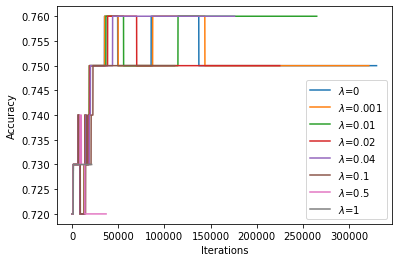

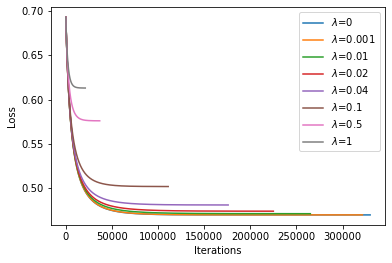

No handles with labels found to put in legend.


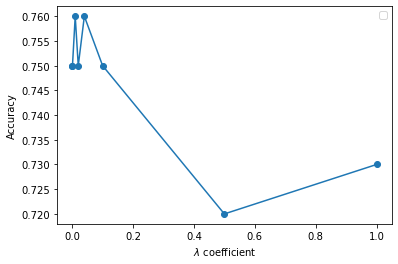

In [39]:
r_lam=[0,0.001,0.01,0.02,0.04,0.1,0.5,1]
compare_lam([600],r_lam)

# Part2 (Text Classification)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegressionCV
import re

In [11]:
stemmer = PorterStemmer()
lem = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()
stop = (stopwords.words("english"))
# DEFINING ANALYZERS
def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
def lemmatizing(doc):
    return (lem.lemmatize(w) for w in analyzer(doc))
def no_stopwords(doc):
    return (w for w in analyzer(doc) if w not in stop)
def lem_stem(doc):
    return (lem.lemmatize(stemmer.stem(w)) for w in analyzer(doc))
def stem_lem(doc):
    return (stemmer.stem(lem.lemmatize(w)) for w in analyzer(doc))

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = text.lower()
    return text

def vectorize(x_train,x_test,cv):
    X_train_counts = cv.fit_transform(x_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_new_counts = cv.transform(x_test)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    return X_train_tfidf,X_new_tfidf

def acc(X_new_tfidf,y_test,cv,clf,last):
    predicted_test = clf.predict(X_new_tfidf)
    acc_test = np.mean(predicted_test == y_test)
    print("accuracy on the test set: ", acc_test)
    if not last: print("\n~next method~\n")
    return None


In [12]:
def processor(x_train,y_train,x_test,y_test, model):

    print("carrying out trials...\n")
    print("1: unigram only")#
    cv = CountVectorizer()
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False) #boolean indicates whether this is the last trial
    
    print("2: unigram,lowercase=False")#
    cv = CountVectorizer(lowercase=False)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)
    
    print("3: unigram, preserving punctuation")#
    cv = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\?\,|\.||\"|\'")
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("4: unigram; removing stopwords")
    cv = CountVectorizer(stop_words=stop)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False) 
    
    print("5: unigram,removing HTML tags")
    cv = CountVectorizer()
    X_train_tfidf,X_new_tfidf=vectorize(x_train.apply(preprocessor),x_test.apply(preprocessor), cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)
    
    #lowercase=False,
    print("6: unigram and bigram")
    cv = CountVectorizer(lowercase=False,ngram_range=(1, 2))
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("7: bigram")
    cv = CountVectorizer(lowercase=False,ngram_range=(2,2))
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("8: unigram; stemming")
    cv = CountVectorizer(lowercase=False,analyzer=stem)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("9: unigram; lemmatizing")
    cv = CountVectorizer(lowercase=False,analyzer=lemmatizing)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("10: stemming lemmas")
    cv = CountVectorizer(lowercase=False,analyzer=stem_lem)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, False)

    print("11: lemmatizing stems")
    cv = CountVectorizer(lowercase=False,analyzer=lem_stem)
    X_train_tfidf,X_new_tfidf=vectorize(x_train,x_test, cv)
    clf = model.fit(X_train_tfidf, y_train)
    acc(X_new_tfidf,y_test, cv, clf, True)
    return None

In [13]:
df_train = pd.read_csv(r"C:\Users\lenovo\Desktop\data_A2\data_A2\fake_news\fake_news_train.csv")
features_train = df_train['text']
labels_train = df_train['label']
df_test = pd.read_csv(r"C:\Users\lenovo\Desktop\data_A2\data_A2\fake_news\fake_news_test.csv")
features_test = df_test['text']
labels_test = df_test['label']

In [16]:
model=LogisticRegression(max_iter=500,solver='liblinear')
processor(features_train,labels_train,features_test,labels_test,model)

carrying out trials...

1: unigram only
accuracy on the test set:  0.71

~next method~

2: unigram,lowercase=False
accuracy on the test set:  0.7236666666666667

~next method~

3: unigram, preserving punctuation
accuracy on the test set:  0.617

~next method~

4: unigram; removing stopwords
accuracy on the test set:  0.6963333333333334

~next method~

5: unigram,removing HTML tags
accuracy on the test set:  0.713

~next method~

6: unigram and bigram
accuracy on the test set:  0.699

~next method~

7: bigram
accuracy on the test set:  0.6636666666666666

~next method~

8: unigram; stemming
accuracy on the test set:  0.71

~next method~

9: unigram; lemmatizing
accuracy on the test set:  0.7083333333333334

~next method~

10: stemming lemmas
accuracy on the test set:  0.7086666666666667

~next method~

11: lemmatizing stems
accuracy on the test set:  0.709


In [17]:
model= LogisticRegressionCV(cv=5, random_state=0,max_iter=500,solver='liblinear')
processor(features_train,labels_train,features_test,labels_test,model)

carrying out trials...

1: unigram only
accuracy on the test set:  0.7353333333333333

~next method~

2: unigram,lowercase=False
accuracy on the test set:  0.7413333333333333

~next method~

3: unigram, preserving punctuation
accuracy on the test set:  0.741

~next method~

4: unigram; removing stopwords
accuracy on the test set:  0.7123333333333334

~next method~

5: unigram,removing HTML tags
accuracy on the test set:  0.747

~next method~

6: unigram and bigram
accuracy on the test set:  0.7796666666666666

~next method~

7: bigram
accuracy on the test set:  0.7496666666666667

~next method~

8: unigram; stemming
accuracy on the test set:  0.7246666666666667

~next method~

9: unigram; lemmatizing
accuracy on the test set:  0.7343333333333333

~next method~

10: stemming lemmas
accuracy on the test set:  0.7253333333333334

~next method~

11: lemmatizing stems
accuracy on the test set:  0.7243333333333334


In [18]:
text_clf = Pipeline([
    ('vect', CountVectorizer(lowercase=False,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
      ('clf', LogisticRegressionCV(cv=5,random_state=0,solver='liblinear')),
])
text_clf.fit(features_train, labels_train)
predicted_test = text_clf.predict(features_test)
acc_test = np.mean(predicted_test == labels_test)
print("Finished: ", acc_test)

Finished:  0.7796666666666666
